# Diamond Price Analysis
---
### Authors:
* Marcin Bereźnicki
* Jakub Burczyk
---
### The problem:
The purpose of the project was to analyze diamond's pricing based on it's weight.

### The goal:
We hope, that after creating sufficient model it will be possible to predict a price for gem given it's mass in carats. 

It may be possible to estimate a price without any trade specific knowledge for example about type of cuts, which could prevent getting ripped off by sellers/buyers.

---

# Table of contents
We highly recommend using provided hyperlinks to sections.

* [Dataset](#dataset)
* [Python modules](#imports)
* [Data Tidying](#data-tidying)
  * [Dropping indexes](#dropping-index)
  * [Mass and price extraction](#mass-and-price-extraction)
  * [Plotting dataset and polynomial fitting](#plotting-dataset-and-polynomial-fitting)
* [Data Analysis](#data-analysis)
  * [Loading dataset](#loading-dataset)
  * [Model 1 - 1st degree polynomial regression](#model-1---linear-regression---1st-degree)
    * [Prior predictive check](#model-1---prior-predictive-check)
    * [Posterior analysis](#model-1---posterior-analysis)
    * [Linear regression](#model-1---stan-linear-regression)
    * [Model parameters](#model-1---model-parameters)
    * [Evaluation](#model-1---evaluation)
      * [Quantiles](#model-1---quantiles)
      * [Predictions and density](#model-1---predictions-and-density-plot)
  * [Model Comparison](#model-comparison)
    * [PSIS-LOO Criterion](#psis-loo-criterion)
    * [WAIC Criterion](#waic-criterion)
    * [Conclusions](#model-comparison---conclusions)

---
# Dataset
[***Return to table of contents***](#table-of-contents)

The data was sourced from [Kaggle.com](https://www.kaggle.com/) which is an online community of data scientists. The dataset can be downloaded [**here**](https://www.kaggle.com/datasets/shivam2503/diamonds).

Dataset contains 53 941 records containing description of 10 diamond properties.

The colums are as follows:
* **price** - in US dollars
* **carat** - weight of the gem
* **cut** - quality of the cut
* **color** - gem's color
* **clarity** - measurement how clear the gem is and it's defects
* **x** - length in milimiters
* **y** - width in milimiters
* **z** - depth in milimiters
* **table** width of top face of the diamond relative to widest point
* **depth** - depth percentage 
\begin{equation}
depth = \frac{z}{mean(x,y)}
\end{equation}

---

---
# Imports
[***Return to table of contents***](#table-of-contents)


Necessary python modules for data analysis.

---

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import random as rd

#import warnings
#warnings.filterwarnings('ignore')

---
# Data tidying
[***Return to table of contents***](#table-of-contents)

Before starting analysis it is necessary to clean up the dataset.

---
## Dropping index
[***Return to table of contents***](#table-of-contents)

The first column contians record id without column name, but for our purpouses it is not necessary thus it gets dropped after loading the dataset file.

---

In [41]:
df = pd.read_csv("data/diamonds.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


---
## Data extraction
[***Return to table of contents***](#table-of-contents)

For our analysis we will consider only one variable affecting gem pricing - it's mass. For each carat value, the average diamond price is calculated.

The data gets trimmed to contain only the necessary information and saved accordingly to ```CSV``` file located at ```./output/caratPrice.csv```.

---

In [56]:
cutRemap = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5}
clarityRemap = {'I1': 1 , 'SI2': 2, 'SI1': 3, 'VS2': 4, 'VS1': 5, 'VVS2': 6, 'VVS1': 7, 'IF': 8}
colorRemap = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 6, 'D': 7}

df=df.replace({"cut": cutRemap})
df=df.replace({"clarity": clarityRemap})
df=df.replace({"color": colorRemap})

print(df)

       carat  cut  color  clarity  depth  table  price     x     y     z
0       0.23    5      6        2   61.5   55.0    326  3.95  3.98  2.43
1       0.21    4      6        3   59.8   61.0    326  3.89  3.84  2.31
2       0.23    2      6        5   56.9   65.0    327  4.05  4.07  2.31
3       0.29    4      2        4   62.4   58.0    334  4.20  4.23  2.63
4       0.31    2      1        2   63.3   58.0    335  4.34  4.35  2.75
...      ...  ...    ...      ...    ...    ...    ...   ...   ...   ...
53935   0.72    5      7        3   60.8   57.0   2757  5.75  5.76  3.50
53936   0.72    2      7        3   63.1   55.0   2757  5.69  5.75  3.61
53937   0.70    3      7        3   62.8   60.0   2757  5.66  5.68  3.56
53938   0.86    4      3        2   61.0   58.0   2757  6.15  6.12  3.74
53939   0.75    5      7        2   62.2   55.0   2757  5.83  5.87  3.64

[53940 rows x 10 columns]


---
## Plotting dataset
[***Return to table of contents***](#table-of-contents)

It is important to see the data before commencing analysis, afterall we should check in case it's utter nonsense as demonstrated [**here**](https://cran.r-project.org/web/packages/datasauRus/vignettes/Datasaurus.html).

---

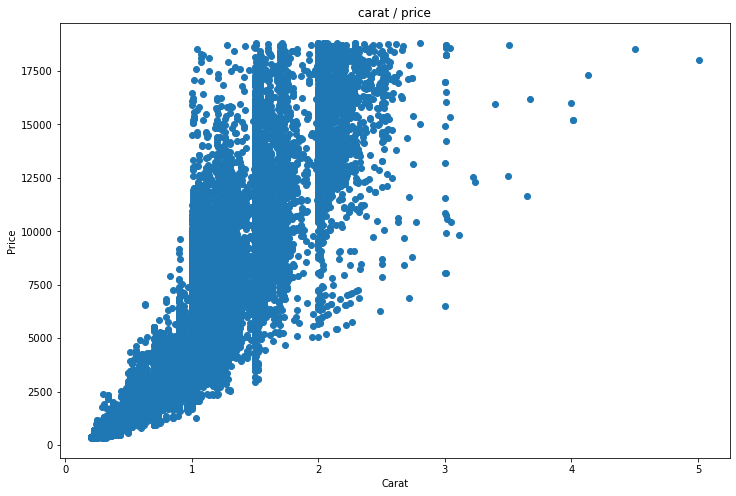

In [57]:
plt.figure(figsize=[12, 8])
plt.scatter(df.carat, df.price)
plt.title('carat / price')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

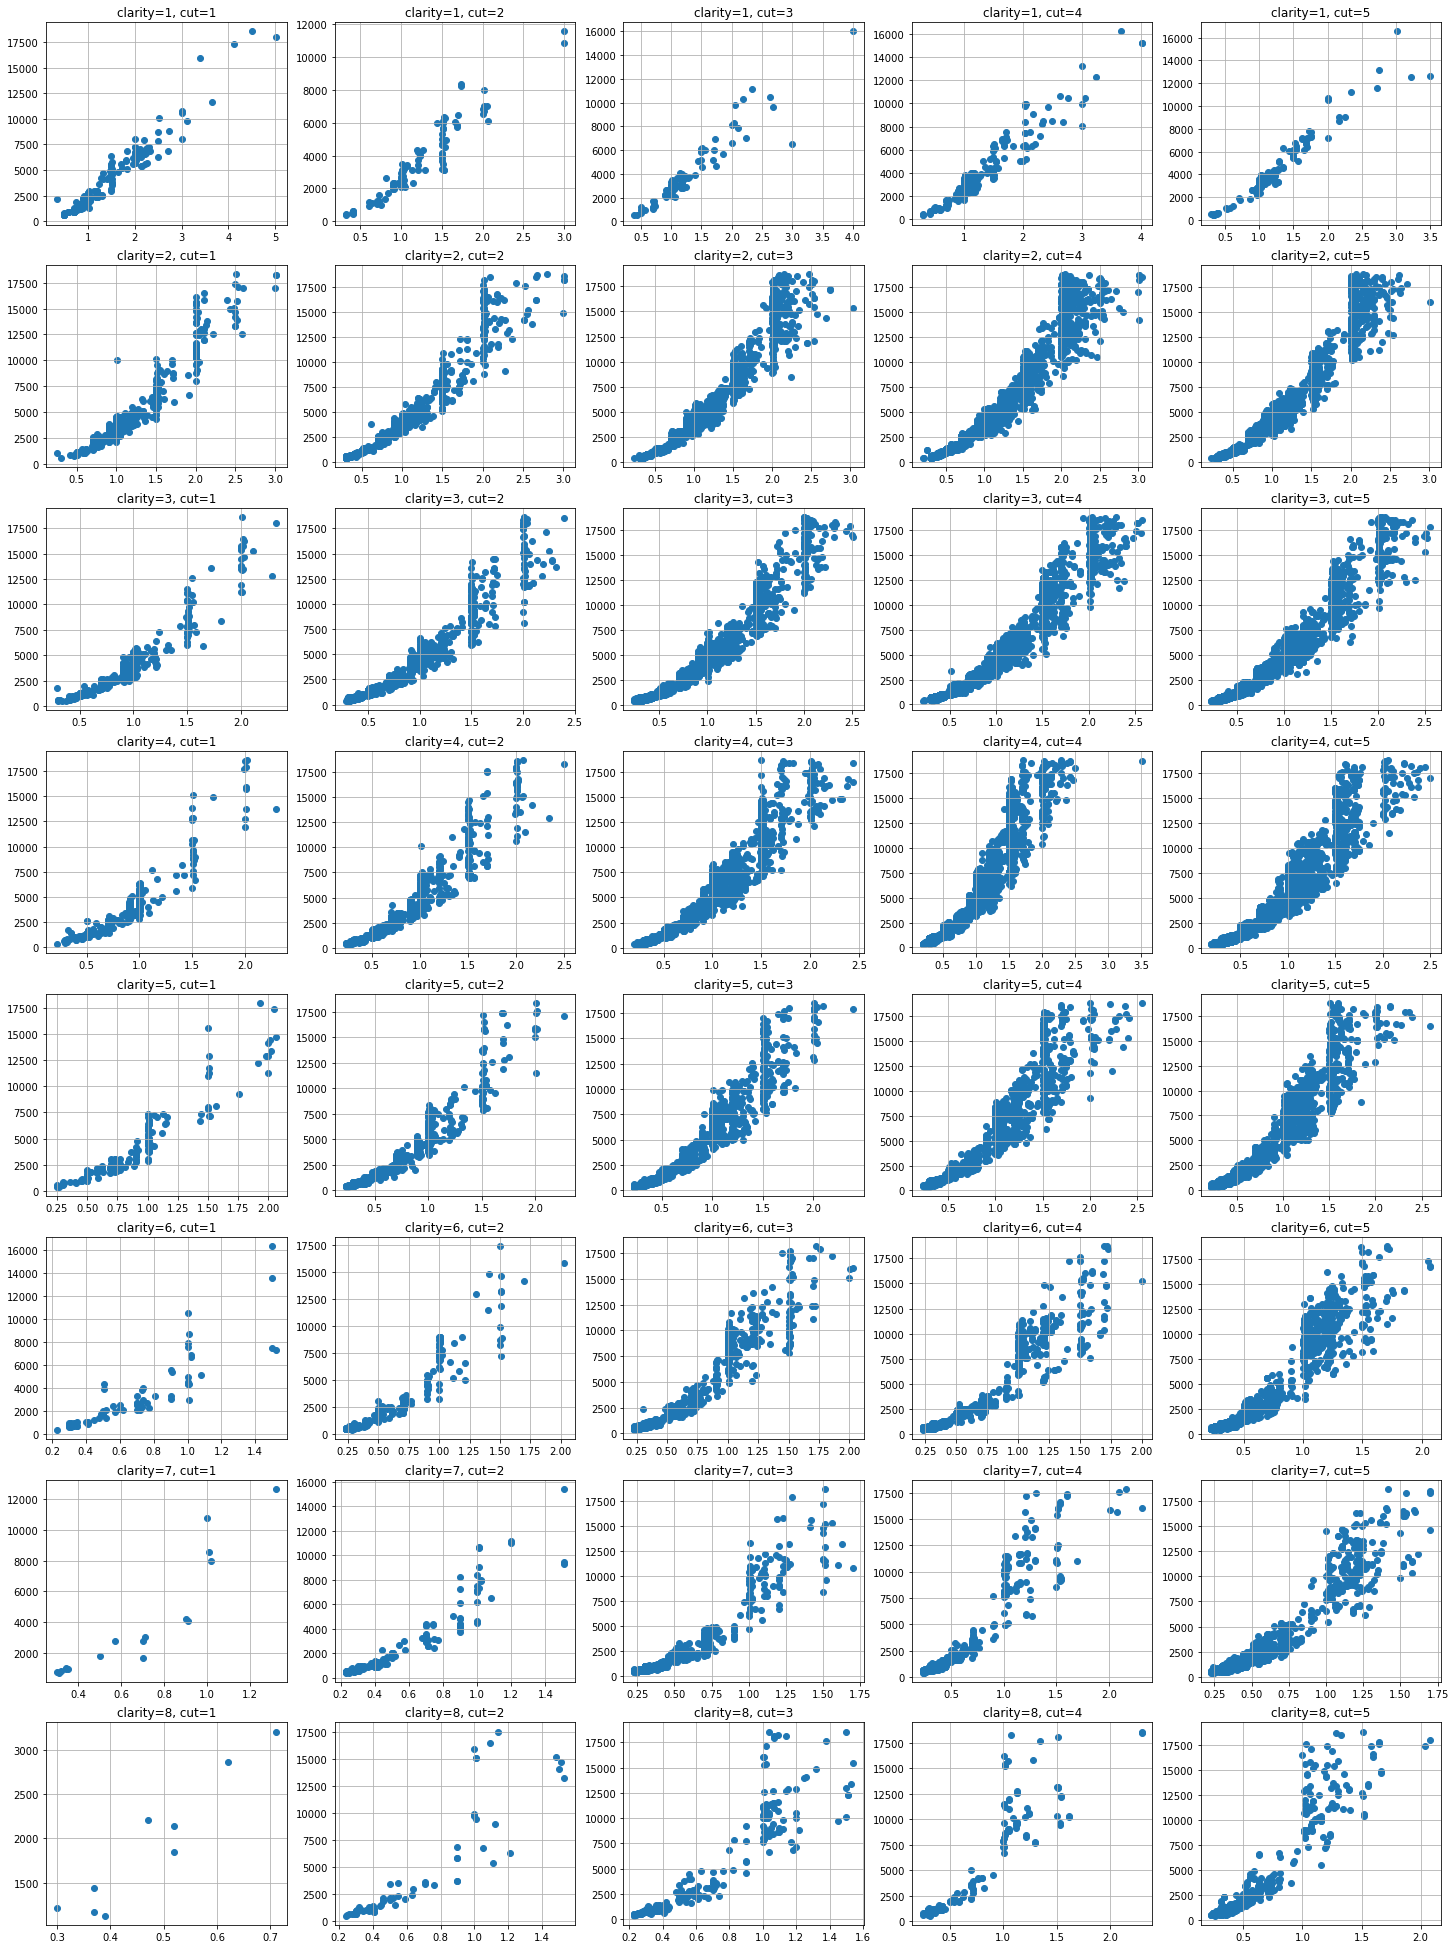

In [63]:
fig, axs = plt.subplots(8,5)
fig.set_size_inches(25, 35)
for i in range(0,8):
    for j in range(0,5):
        df_temp = df.loc[df['clarity'] == i+1]
        df_temp = df_temp.loc[df_temp['cut'] == j+1]
        axs[i][j].scatter(df_temp.carat, df_temp.price)
        axs[i][j].grid()
        axs[i][j].set_title(f'clarity={i+1}, cut={j+1}')
plt.show()

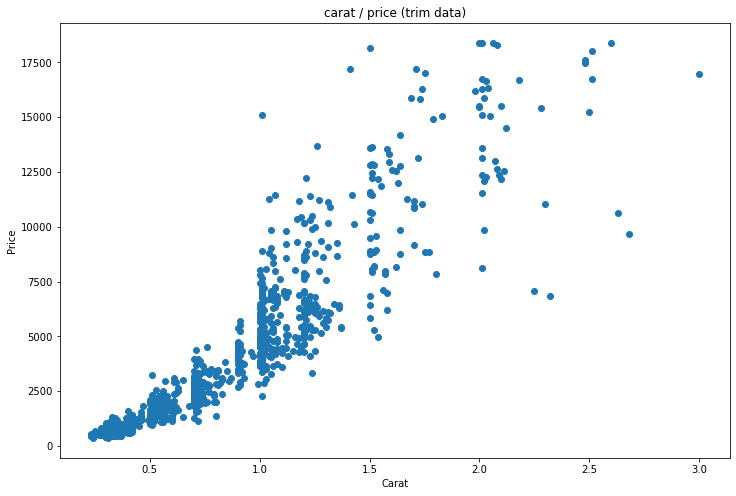

In [75]:
df_trim = df.sample(n = 1000)
df_trim.reset_index(drop=True, inplace=True)

plt.figure(figsize=[12, 8])
plt.scatter(df_trim.carat, df_trim.price)
plt.title('carat / price (trim data)')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

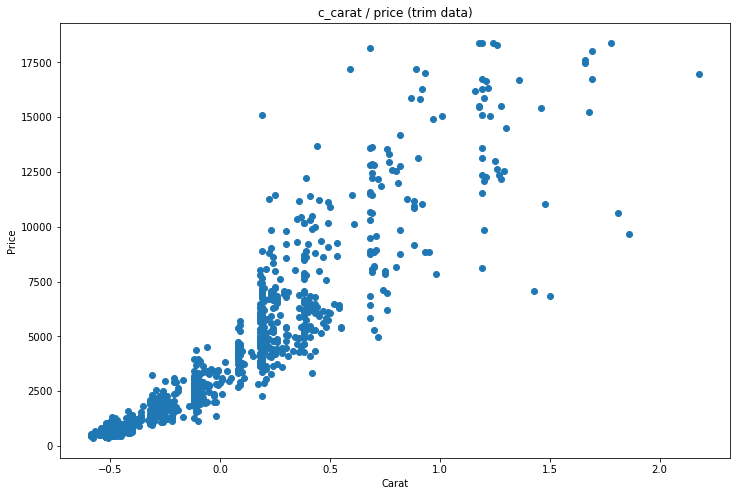

In [82]:
df_trim['c_carat'] = df_trim.carat - df_trim.carat.mean()

plt.figure(figsize=[12, 8])
plt.scatter(df_trim.c_carat, df_trim.price)
plt.title('c_carat / price (trim data)')
plt.xlabel("Carat")
plt.ylabel("Price")
plt.show()

---
# Data Analysis
[***Return to table of contents***](#table-of-contents)

For analysis we have created 3 bayesian models.

* Model 1 - uses 1st degree polynomial (a linear function)
* Model 2 - 

Expanding the first model by increasing the order of the polynomial allows for a better fit of the model to the observations, in terms of the data, and for value prediction. The third model is the departure from polynomial regression to the simulating from a Gaussian Process conditional on non-Gaussian observations.

The equations, parameters and differences of individual models are presented in the corresponding chapters.

---

## Test

In [83]:
model_test = CmdStanModel(stan_file='stanfiles/model_1.stan')

INFO:cmdstanpy:compiling stan file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.stan to exe file E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.exe
INFO:cmdstanpy:compiled model executable: E:\Programowanie\Microsoft VS Code Projects\Data Analytics\DA_DiamondModel\stanfiles\model_1.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/Marcin/AppData/Local/Temp/tmpjd0bagk6/tmptivoxyom.hpp C:/Users/Marcin/AppData/Local/Temp/tmpjd0bagk6/tmptivoxyom.stan
Warning in 'C:/Users/Marcin/AppData/Local/Temp/tmpjd0bagk6/tmptivoxyom.stan', line 37, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -m64 -D_REENTRANT -Wall -Wno-unuse

In [84]:
data_sim={'N':len(df_trim), 'c_carat': df_trim.c_carat, 'cut': df_trim.cut, 'clarity': df_trim.clarity, 'price': df_trim.price}
model_sim = model_test.sample(data=data_sim)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


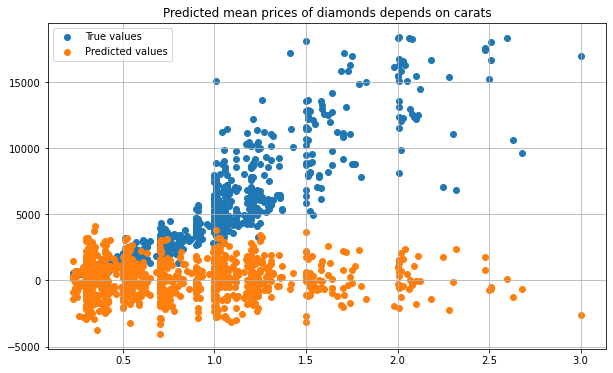

In [86]:
price_sim = model_sim.stan_variable('price_sim')
plt.figure(figsize=[10,6])
plt.scatter(df_trim.carat, df_trim.price)
plt.scatter(df_trim.carat, price_sim[1])
plt.title("Predicted mean prices of diamonds depends on carats")
plt.legend(["True values", "Predicted values"])
plt.grid()
plt.show()